In [1]:
import warnings                           
warnings.filterwarnings('ignore')
from pandas.plotting import lag_plot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from utils import mean_absolute_percentage_error, timeseries_train_test_split, train_test_split, time_lags_generation, compute_model_error, optimal_leg_search_1d 

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
data.head()

,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [3]:
# remove the last row
data = data.iloc[:-1]

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,meals
date,
2018-04-06,32.0
2018-04-07,8.0
2018-04-08,4.0
2018-04-09,14.0
2018-04-10,5.0


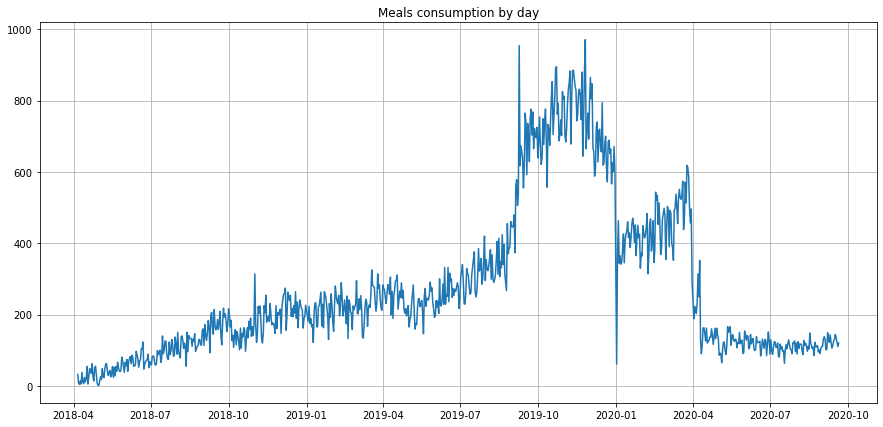

In [5]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

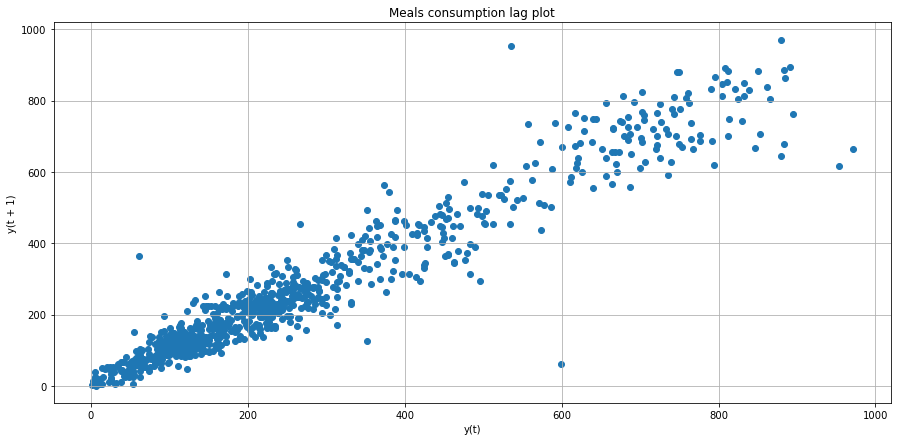

In [6]:
plt.figure(figsize=(15,7))
lag_plot(data)
plt.title('Meals consumption lag plot')
plt.grid(True)
plt.show()

In [7]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [8]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)

time_data = time_lags_generation(time_data, 1, 21)
print(time_data.shape)
time_data.tail()

(896, 21)


,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
date,,,,,,,,,,,,,,,,,,,,,
2020-09-16,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,...,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0
2020-09-17,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,...,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0
2020-09-18,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,...,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0
2020-09-19,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,...,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0
2020-09-20,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,...,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0


In [9]:
time_data.tail(10)

,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
date,,,,,,,,,,,,,,,,,,,,,
2020-09-11,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,...,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0
2020-09-12,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,...,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0
2020-09-13,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,...,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0
2020-09-14,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,...,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0
2020-09-15,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,...,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0
2020-09-16,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,...,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0
2020-09-17,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,...,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0
2020-09-18,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,...,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0
2020-09-19,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,...,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0


In [10]:
tscv = TimeSeriesSplit(n_splits=5)
X_train, X_test, y_train, y_test = train_test_split(time_data)

In [11]:
print(X_train.shape, X_test.shape)

(613, 20) (263, 20)


In [12]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    return lr

In [13]:
lr = linear_regression_model(X_train, y_train)

In [14]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

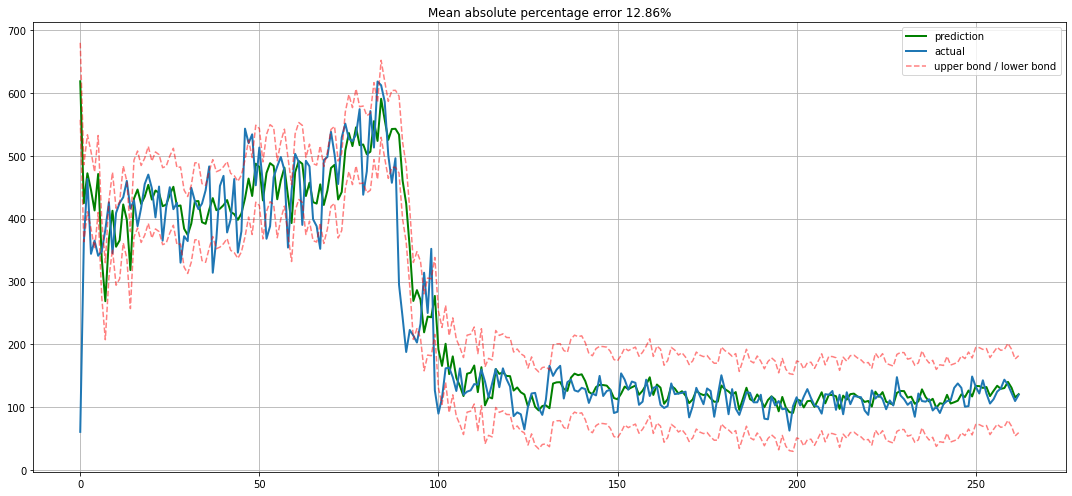

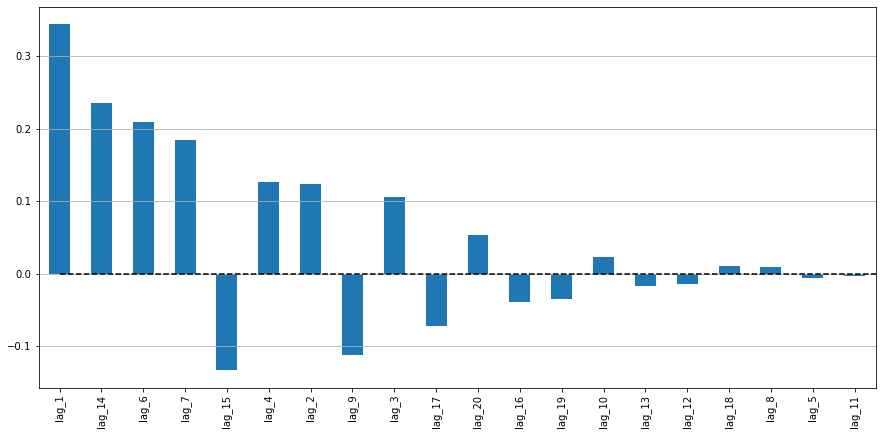

In [15]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)

### Regularization and feature selection

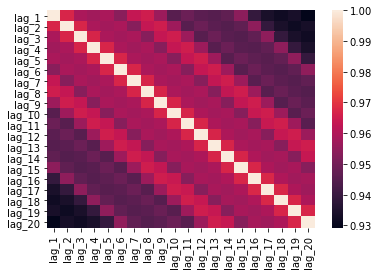

In [16]:
sns.heatmap(X_train.corr());

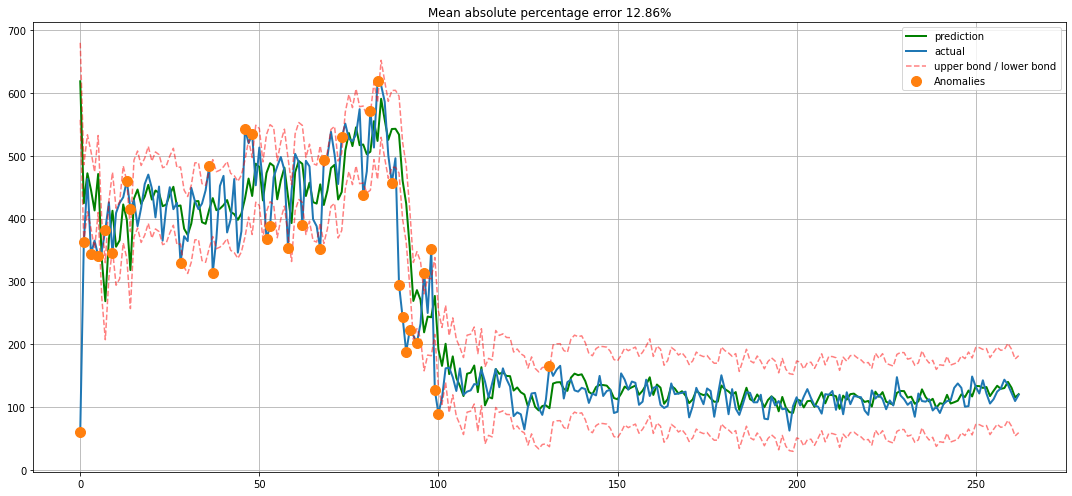

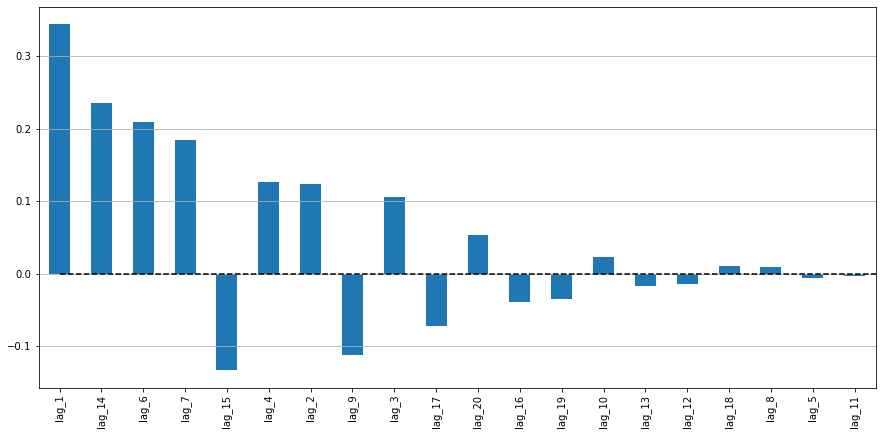

In [17]:


ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

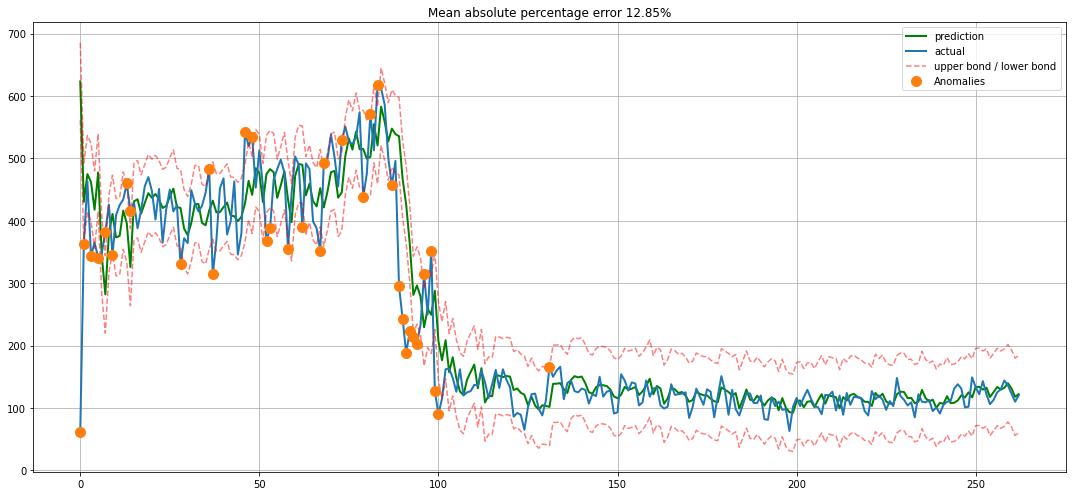

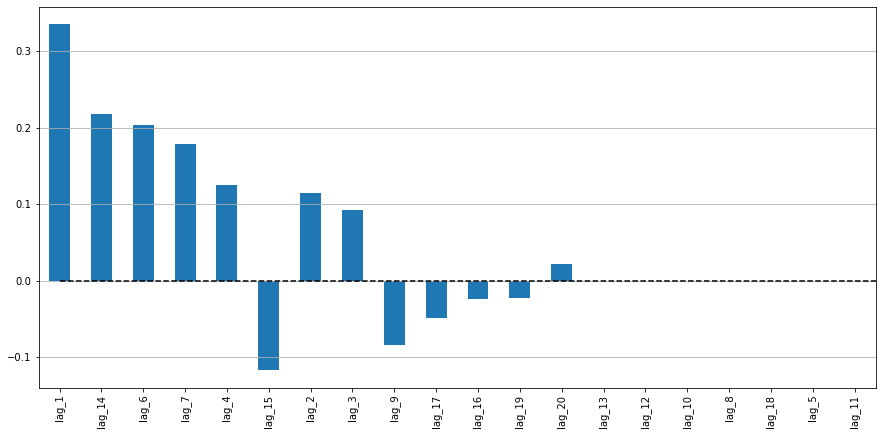

In [18]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Introducing a slight optimization, kind of a grid search of an optimal lags combination

In [19]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [20]:
result_dict = {}
lag_range = list(range(5,57))
start_lag = 1

for j in lag_range:

    key = (start_lag, j)
    df = time_lags_generation(time_data, 1, j)
    x_train, x_test, y_train, y_test = train_test_split(df)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    prediction = lr.predict(x_test)
    error = mean_absolute_percentage_error(prediction, y_test)
    
    result_dict[key] = error

In [21]:
sorted_dict = sorted(result_dict.items(), key=lambda kv: kv[1])
#sorted_dict

In [22]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [23]:
result_dict = {}
lag_range = list(range(5,57))
start_lag = 1

for j in lag_range:

    key = (start_lag, j)
    df = time_lags_generation(time_data, 1, j)
    x_train, x_test, y_train, y_test = train_test_split(df)
    tscv = TimeSeriesSplit(n_splits=5)
    lasso = LassoCV(cv=tscv)
    lasso.fit(x_train, y_train)
    prediction = lasso.predict(x_test)
    error = mean_absolute_percentage_error(prediction, y_test)
    
    result_dict[key] = error

In [24]:
sorted_dict = sorted(result_dict.items(), key=lambda kv: kv[1])
sorted_dict

[((1, 24), 12.609519542778497),
 ((1, 25), 12.610720438914491),
 ((1, 26), 12.663385554136063),
 ((1, 23), 12.733065068428095),
 ((1, 27), 12.755818193150951),
 ((1, 28), 12.756201226454117),
 ((1, 29), 12.757892605964303),
 ((1, 21), 12.853670580975402),
 ((1, 17), 12.872699114544101),
 ((1, 22), 12.881675740175492),
 ((1, 19), 12.893279580125824),
 ((1, 18), 12.896313687360156),
 ((1, 20), 12.898514393301008),
 ((1, 16), 12.925347507217635),
 ((1, 15), 12.950131338228005),
 ((1, 6), 13.112698244011892),
 ((1, 5), 13.17393153576456),
 ((1, 30), 13.265049124047623),
 ((1, 8), 13.371001960073736),
 ((1, 9), 13.371589840971703),
 ((1, 7), 13.373161040722389),
 ((1, 10), 13.551368673443074),
 ((1, 13), 13.579638621491718),
 ((1, 11), 13.582813860084816),
 ((1, 12), 13.58406881396286),
 ((1, 14), 13.625817750293546),
 ((1, 31), 13.75228818793458),
 ((1, 33), 13.84027734331322),
 ((1, 32), 13.905457866176038),
 ((1, 37), 14.073575592547074),
 ((1, 40), 14.08916995088536),
 ((1, 34), 14.0947

In [25]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [26]:
result_dict = {}
lag_range = list(range(5,57))
start_lag = 1
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv)

In [27]:
lr_dict_errors = optimal_leg_search_1d(start_lag, lag_range, time_data, lr)
sorted_dict_lr = sorted(lr_dict_errors.items(), key=lambda kv: kv[1])
sorted_dict_lr

[((1, 25), 12.832277922892734),
 ((1, 21), 12.86487283092976),
 ((1, 24), 12.886795719773476),
 ((1, 23), 12.914041058647138),
 ((1, 22), 12.943133219564174),
 ((1, 26), 13.006524368428444),
 ((1, 20), 13.019661348327158),
 ((1, 17), 13.02187975840273),
 ((1, 19), 13.042962169206666),
 ((1, 18), 13.069735734616767),
 ((1, 16), 13.08753253660232),
 ((1, 15), 13.098734738214567),
 ((1, 6), 13.112267111000401),
 ((1, 5), 13.17267590350909),
 ((1, 27), 13.225527329480355),
 ((1, 29), 13.296545822414915),
 ((1, 28), 13.297224588712997),
 ((1, 7), 13.352608592655699),
 ((1, 8), 13.358253471707812),
 ((1, 9), 13.376507046549808),
 ((1, 10), 13.686678611041328),
 ((1, 30), 13.687312978970438),
 ((1, 11), 13.69845211015702),
 ((1, 14), 13.711867860486649),
 ((1, 12), 13.71821694712215),
 ((1, 13), 13.719946078667),
 ((1, 31), 14.28573188153585),
 ((1, 33), 14.440219880231256),
 ((1, 34), 14.66619407179871),
 ((1, 32), 14.683869546821477),
 ((1, 35), 15.259189022995457),
 ((1, 37), 15.5365633042

In [28]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [29]:
lasso_dict_errors = optimal_leg_search_1d(start_lag, lag_range, time_data, lasso)
sorted_dict_lasso = sorted(lasso_dict_errors.items(), key=lambda kv: kv[1])
sorted_dict_lasso

[((1, 24), 12.609519542778497),
 ((1, 25), 12.610720438914491),
 ((1, 26), 12.663385554136063),
 ((1, 23), 12.733065068428095),
 ((1, 27), 12.755818193150951),
 ((1, 28), 12.756201226454117),
 ((1, 29), 12.757892605964303),
 ((1, 21), 12.853670580975402),
 ((1, 17), 12.872699114544101),
 ((1, 22), 12.881675740175492),
 ((1, 19), 12.893279580125824),
 ((1, 18), 12.896313687360156),
 ((1, 20), 12.898514393301008),
 ((1, 16), 12.925347507217635),
 ((1, 15), 12.950131338228005),
 ((1, 6), 13.112698244011892),
 ((1, 5), 13.17393153576456),
 ((1, 30), 13.265049124047623),
 ((1, 8), 13.371001960073736),
 ((1, 9), 13.371589840971703),
 ((1, 7), 13.373161040722389),
 ((1, 10), 13.551368673443074),
 ((1, 13), 13.579638621491718),
 ((1, 11), 13.582813860084816),
 ((1, 12), 13.58406881396286),
 ((1, 14), 13.625817750293546),
 ((1, 31), 13.75228818793458),
 ((1, 33), 13.84027734331322),
 ((1, 32), 13.905457866176038),
 ((1, 37), 14.073575592547074),
 ((1, 40), 14.08916995088536),
 ((1, 34), 14.0947

In [30]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]
time_data.shape

(896, 1)

In [31]:
result_dict = {}
lag_range = list(range(7,57))
start_lag = list(range(1,6))

for i in start_lag:
    time_data = pd.DataFrame(data.meals.copy())
    time_data.columns = ["target"]
    for j in lag_range:

        key = (i, j)
        df = time_lags_generation(time_data, i, j)
        x_train, x_test, y_train, y_test = train_test_split(df)
        tscv = TimeSeriesSplit(n_splits=5)
        lasso = LassoCV(cv=tscv)
        lasso.fit(x_train, y_train)
        prediction = lasso.predict(x_test)
        error = mean_absolute_percentage_error(prediction, y_test)

        result_dict[key] = error

In [32]:
sorted_dict = sorted(result_dict.items(), key=lambda kv: kv[1])
sorted_dict

[((1, 24), 12.609519542778497),
 ((1, 25), 12.610720438914491),
 ((1, 26), 12.663385554136063),
 ((1, 23), 12.733065068428095),
 ((1, 27), 12.755818193150951),
 ((1, 28), 12.756201226454117),
 ((1, 29), 12.757892605964303),
 ((1, 21), 12.853670580975402),
 ((1, 17), 12.872699114544101),
 ((1, 22), 12.881675740175492),
 ((1, 19), 12.893279580125824),
 ((1, 18), 12.896313687360156),
 ((1, 20), 12.898514393301008),
 ((1, 16), 12.925347507217635),
 ((1, 15), 12.950131338228005),
 ((1, 30), 13.265049124047623),
 ((1, 8), 13.371001960073736),
 ((1, 9), 13.371589840971703),
 ((1, 7), 13.373161040722389),
 ((1, 10), 13.551368673443074),
 ((1, 13), 13.579638621491718),
 ((1, 11), 13.582813860084816),
 ((1, 12), 13.58406881396286),
 ((1, 14), 13.625817750293546),
 ((2, 24), 13.686739306677994),
 ((2, 25), 13.696857930108456),
 ((1, 31), 13.75228818793458),
 ((2, 26), 13.755133096622796),
 ((1, 33), 13.84027734331322),
 ((2, 23), 13.8644753768424),
 ((1, 32), 13.905457866176038),
 ((2, 22), 13.91